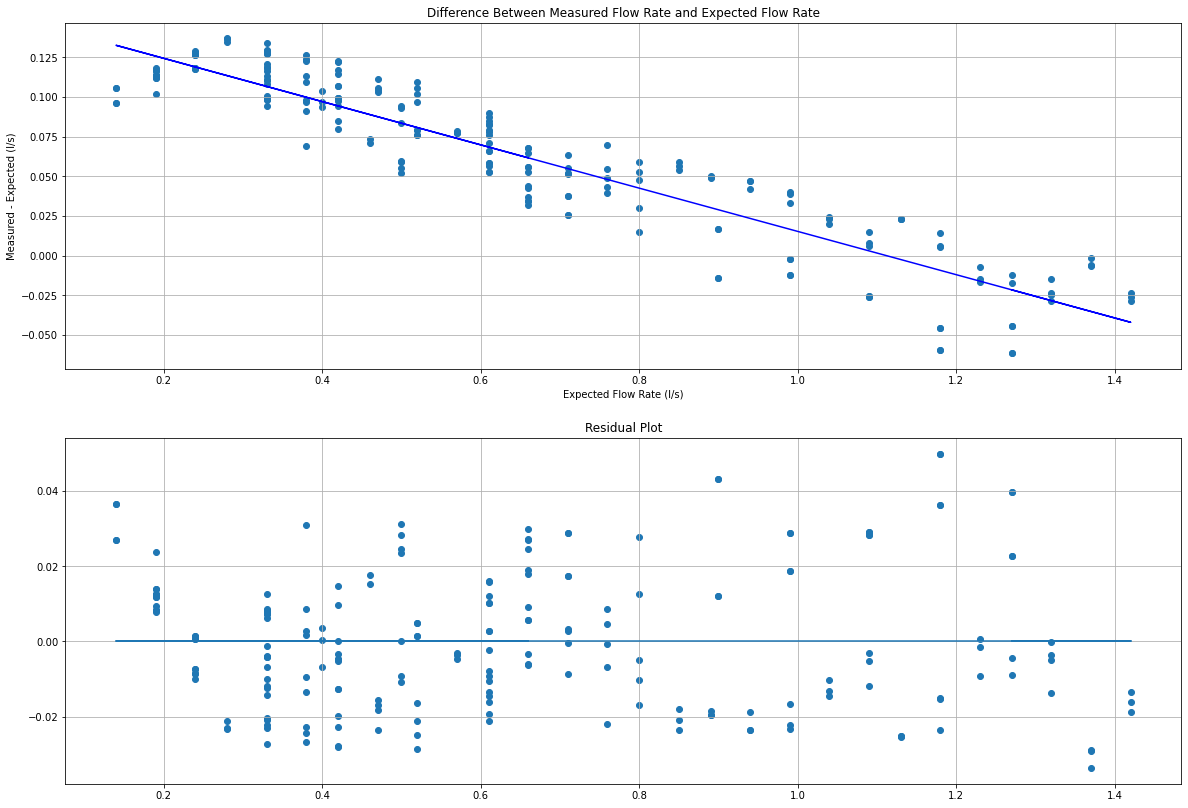

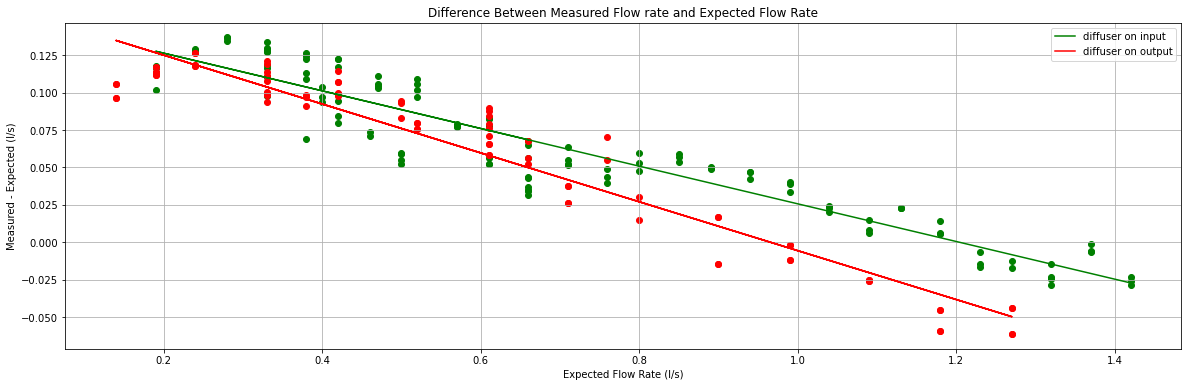

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import array as array

plt.rcParams["savefig.facecolor"] = "w"
FIGURE_DIRECTORY = '/Users/Gavin/Projects/Ventilator Flow Monitor/Plots/'

# each table in tables represents an entire sample, including pump off data. Therefore even indices are pump off data while odd are pump on (since we
# always run a pump off run first

tables = {
    "n": [],
    "In": [],
    "Mid": [],
    "Out": [],
    "Ambient": [],
    "t": [],
    "flowRate": [],
    "diffuserOnFront": [],
}
airDensity = 1.22  # kg/m^3
A1 = 0.02 * 0.025  # m^2 -- tube area
A2 = 0.02 * 0.005  # m^2 -- constriction area

# read the data into the tables dictionary
with open("/Users/Gavin/Projects/Ventilator Flow Monitor/Data/Initial Insert Data.csv") as f:
    n, In, Mid, Out, Ambient, t = [], [], [], [], [], []
    N = 0
    i = 0
    onFront = True
    idx = 0
    for line in f:
        idx += 1
        #if idx > 483:
        #    break
        row = line.split(",")
        if "output" in row[0]:
            onFront = False
        if "input" in row[0]:
            onFront = True
        if "Pump Off Samples" in line:
            tables["flowRate"].append(0)
            N = int(row[2].split("=")[-1])
        elif "flow rate" in line:
            tables["flowRate"].append(float(row[1].split("=")[-1]))
            N = int(row[2].split("=")[-1])
        try:
            n.append(int(row[0]))
            In.append(float(row[1]))
            Mid.append(float(row[2]))
            Out.append(float(row[3]))
            Ambient.append(float(row[4]))
            t.append(float(row[5]))
            i += 1
            if i == N:
                tables["n"].append(np.array(n))
                tables["In"].append(np.array(In))
                tables["Mid"].append(np.array(Mid))
                tables["Out"].append(np.array(Out))
                tables["Ambient"].append(np.array(Ambient))
                tables["t"].append(np.array(t))
                tables["diffuserOnFront"].append(onFront)

                n, In, Mid, Out, Ambient, t = [], [], [], [], [], []
                i = 0
        except:
            continue

# calculate the flow rates for all runs
inputOffAverages = np.array(
    [
        np.mean(inputPressures)
        for idx, inputPressures in enumerate(tables["In"])
        if idx % 2 == 0
    ]
)
inputOnAverages = np.array(
    [
        np.mean(inputPressures)
        for idx, inputPressures in enumerate(tables["In"])
        if idx % 2 == 1
    ]
)
midOffAverages = np.array(
    [
        np.mean(midPressures)
        for idx, midPressures in enumerate(tables["Mid"])
        if idx % 2 == 0
    ]
)
midOnAverages = np.array(
    [
        np.mean(midPressures)
        for idx, midPressures in enumerate(tables["Mid"])
        if idx % 2 == 1
    ]
)
ambientOffAverages = np.array(
    [
        np.mean(ambientPressures)
        for idx, ambientPressures in enumerate(tables['Ambient'])
        if idx % 2 == 0
    ]
)
ambientOnAverages = np.array(
    [
        np.mean(ambientPressures)
        for idx, ambientPressures in enumerate(tables['Ambient'])
        if idx % 2 == 1
    ]
)
inputAdjustedAverages = inputOnAverages - inputOffAverages - (ambientOnAverages - ambientOffAverages)
midAdjustedAverages = midOnAverages - midOffAverages - (ambientOnAverages - ambientOffAverages)
deltaPressures = inputAdjustedAverages - midAdjustedAverages
calculatedFlowRates = (
    1000 * (2 * deltaPressures / (airDensity *
                                  (1 / A2 ** 2 - 1 / A1 ** 2))) ** 0.5
)
expectedFlowRates = np.array(
    [flowRate for flowRate in tables["flowRate"] if flowRate != 0]
)
differences = calculatedFlowRates - expectedFlowRates

# plotting stuff
fig1 = plt.figure()
ax1 = fig1.add_subplot(211)
ax1.scatter(expectedFlowRates, differences)
ax1.set_xlabel("Expected Flow Rate (l/s)")
ax1.set_ylabel("Measured - Expected (l/s)")
m, b = np.polyfit(expectedFlowRates, differences, 1)
ax1.plot(expectedFlowRates, m * expectedFlowRates +
         b, color="blue", label="all points")
ax1.set_title(
    "Difference Between Measured Flow Rate and Expected Flow Rate")
ax1.grid()
ax8 = fig1.add_subplot(212)
residuals = m * expectedFlowRates + b - differences
ax8.scatter(expectedFlowRates, residuals)
m, b = np.polyfit(expectedFlowRates, residuals, 1)
ax8.plot(expectedFlowRates, m * expectedFlowRates + b)
ax8.grid()
ax8.set_title("Residual Plot")
fig1.set_size_inches(20, 14)
fig1.savefig(FIGURE_DIRECTORY + "Measured Flow Rate Minus Expected", dpi=500)

# calculating flow rates for diffuser on input
diffuserInputIndices = np.where(
    np.array(tables["diffuserOnFront"]) == True)[-1]
diffuserInputOffIndices = np.array(
    [idx for idx in diffuserInputIndices if idx % 2 == 0]
)
diffuserInputOnIndices = np.array(
    [idx for idx in diffuserInputIndices if idx % 2 == 1])
diffuserInput_inputOffAverages = np.array(
    [
        np.mean(arr)
        for arr in np.array(tables["In"], dtype=object)[diffuserInputOffIndices]
    ]
)
diffuserInput_inputOnAverages = np.array(
    [
        np.mean(arr)
        for arr in np.array(tables["In"], dtype=object)[diffuserInputOnIndices]
    ]
)
diffuserInput_midOffAverages = np.array(
    [
        np.mean(arr)
        for arr in np.array(tables["Mid"], dtype=object)[diffuserInputOffIndices]
    ]
)
diffuserInput_midOnAverages = np.array(
    [
        np.mean(arr)
        for arr in np.array(tables["Mid"], dtype=object)[diffuserInputOnIndices]
    ]
)
diffuserInput_inputAdjustedAverages = (
    diffuserInput_inputOnAverages - diffuserInput_inputOffAverages
)
diffuserInput_midAdjustedAVerages = (
    diffuserInput_midOnAverages - diffuserInput_midOffAverages
)
diffuserInput_deltaPressures = (
    diffuserInput_inputAdjustedAverages - diffuserInput_midAdjustedAVerages
)
diffuserInput_calculatedFlowRates = (
    1000
    * (2 * diffuserInput_deltaPressures / (airDensity * (1 / A2 ** 2 - 1 / A1 ** 2)))
    ** 0.5
)
diffuserInput_expectedFlowRates = np.array(tables["flowRate"])[
    diffuserInputOnIndices]
diffuserInput_differences = (
    diffuserInput_calculatedFlowRates - diffuserInput_expectedFlowRates
)

# plotting stuff
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.scatter(diffuserInput_expectedFlowRates,
            diffuserInput_differences, color="green")
m, b = np.polyfit(diffuserInput_expectedFlowRates,
                  diffuserInput_differences, 1)
ax2.plot(
    diffuserInput_expectedFlowRates,
    m * diffuserInput_expectedFlowRates + b,
    color="green",
    label="diffuser on input",
)

# calculating flow rates for diffuser on output
try:
    diffuserOutputIndices = np.where(
        np.array(tables["diffuserOnFront"]) == False)[-1]
    diffuserOutputOffIndices = np.array(
        [idx for idx in diffuserOutputIndices if idx % 2 == 0]
    )
    diffuserOutputOnIndices = np.array(
        [idx for idx in diffuserOutputIndices if idx % 2 == 1]
    )
    diffuserOutput_inputOffAverages = np.array(
        [
            np.mean(arr)
            for arr in np.array(tables["In"], dtype=object)[diffuserOutputOffIndices]
        ]
    )
    diffuserOutput_inputOnAverages = np.array(
        [
            np.mean(arr)
            for arr in np.array(tables["In"], dtype=object)[diffuserOutputOnIndices]
        ]
    )
    diffuserOutput_midOffAverages = np.array(
        [
            np.mean(arr)
            for arr in np.array(tables["Mid"], dtype=object)[diffuserOutputOffIndices]
        ]
    )
    diffuserOutput_midOnAverages = np.array(
        [
            np.mean(arr)
            for arr in np.array(tables["Mid"], dtype=object)[diffuserOutputOnIndices]
        ]
    )
    diffuserOutput_inputAdjustedAverages = (
        diffuserOutput_inputOnAverages - diffuserOutput_inputOffAverages
    )
    diffuserOutput_midAdjustedAVerages = (
        diffuserOutput_midOnAverages - diffuserOutput_midOffAverages
    )
    diffuserOutput_deltaPressures = (
        diffuserOutput_inputAdjustedAverages - diffuserOutput_midAdjustedAVerages
    )
    diffuserOutput_calculatedFlowRates = (
        1000
        * (2 * diffuserOutput_deltaPressures / (airDensity * (1 / A2 ** 2 - 1 / A1 ** 2)))
        ** 0.5
    )
    diffuserOutput_expectedFlowRates = np.array(
        [tables["flowRate"][idx] for idx in diffuserOutputOnIndices]
    )
    diffuserOutput_differences = (
        diffuserOutput_calculatedFlowRates - diffuserOutput_expectedFlowRates
    )

    # plotting stuff
    ax2.scatter(diffuserOutput_expectedFlowRates,
                diffuserOutput_differences, color="red")
    m, b = np.polyfit(diffuserOutput_expectedFlowRates,
                      diffuserOutput_differences, 1)
    ax2.plot(
        diffuserOutput_expectedFlowRates,
        m * diffuserOutput_expectedFlowRates + b,
        color="red",
        label="diffuser on output",
    )

    ax2.set_title(
        "Difference Between Measured Flow rate and Expected Flow Rate")
    ax2.grid()
    ax2.legend()
    ax2.set_xlabel("Expected Flow Rate (l/s)")
    ax2.set_ylabel("Measured - Expected (l/s)")
    fig2.set_size_inches(20, 6)
    fig2.savefig(FIGURE_DIRECTORY + "Measured Flow Rate Minus Expected (Diffuser)", dpi=500)
except:
    print('No data with diffuser on output')

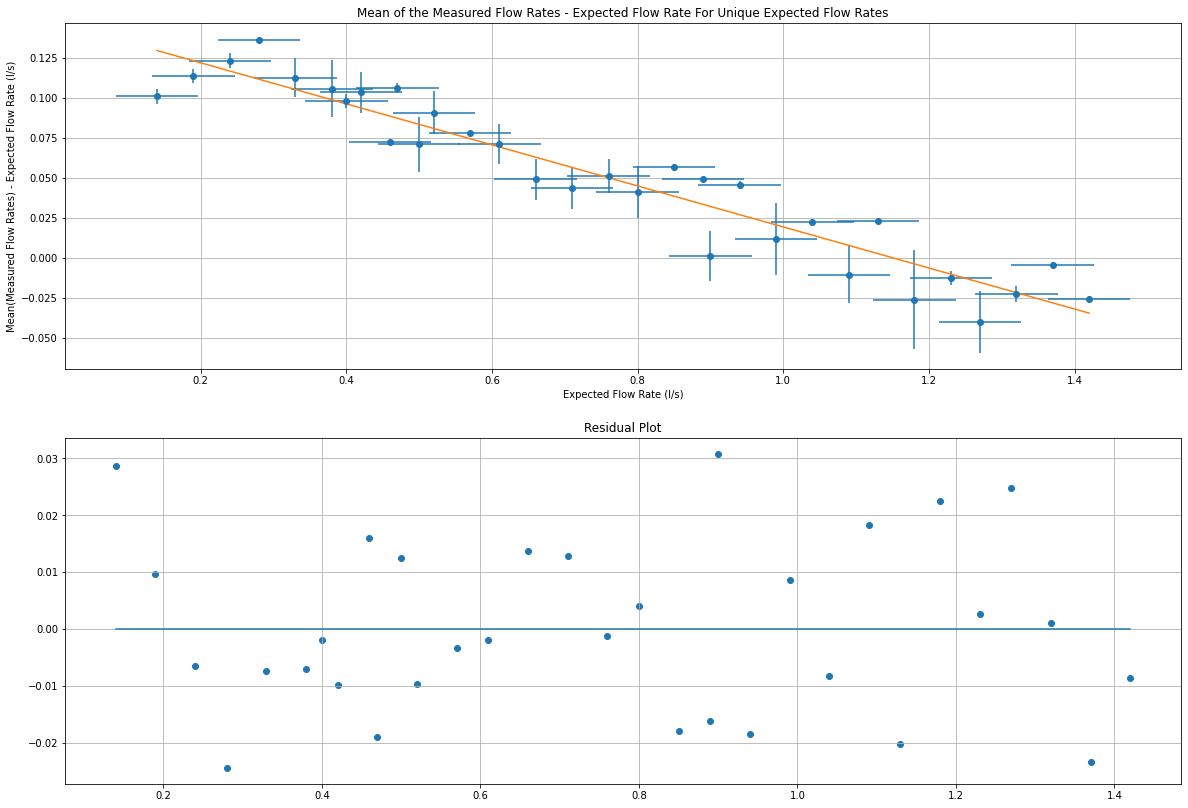

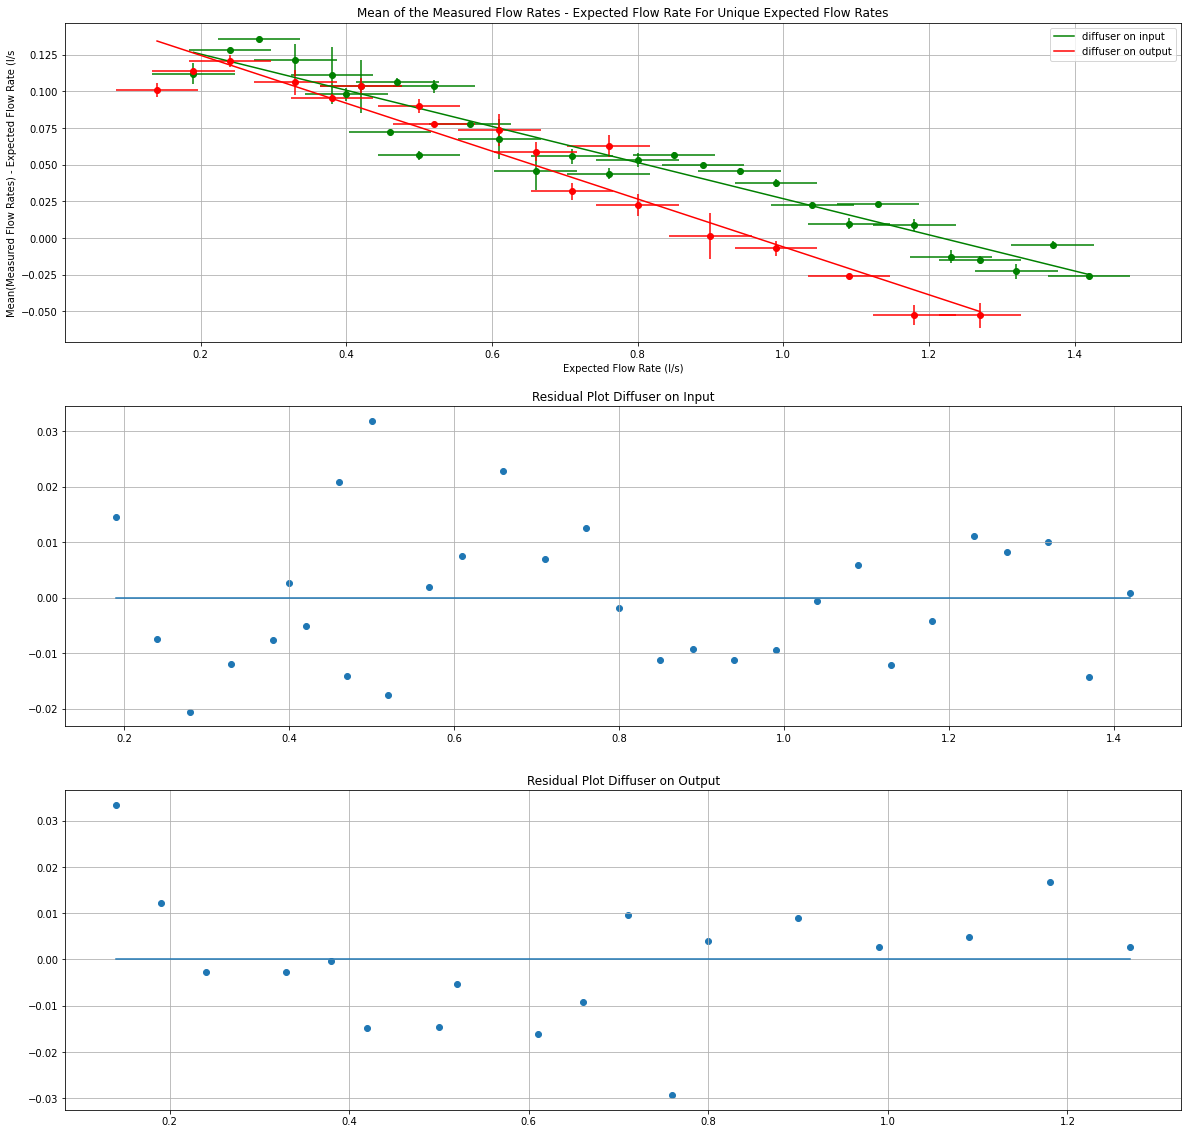

In [4]:
# calculating the mean of our calculated flow rates for each unique flow rate. Differentiating between diffuser on input and diffuser on output as well

uniqueExpectedFlowRates = np.delete(np.unique(tables["flowRate"]), 0)
means = np.empty(len(uniqueExpectedFlowRates))
standardDeviations = np.empty(len(uniqueExpectedFlowRates))
diffuserInput_standardDeviations = []
diffuserInput_means = []
diffuserInput_adjustedIndices = []
diffuserOutput_adjustedIndices = []
diffuserOutput_means = []
diffuserOutput_standardDeviations = []
for i, uniqueExpectedFlowRate in enumerate(uniqueExpectedFlowRates):
    calculated = []
    diffuserInput_calculated = []
    diffuserOutput_calculated = []
    for j, expectedFlowRate in enumerate(expectedFlowRates):
        if uniqueExpectedFlowRate == expectedFlowRate:
            calculated.append(calculatedFlowRates[j])
            if tables["diffuserOnFront"][::2][j] == True:
                diffuserInput_calculated.append(calculatedFlowRates[j])
                diffuserInput_adjustedIndices.append(i)
            else:
                diffuserOutput_calculated.append(calculatedFlowRates[j])
                diffuserOutput_adjustedIndices.append(i)
    standardDeviations[i] = np.std(calculated)
    means[i] = np.mean(calculated)
    if len(diffuserInput_calculated) > 0:
        diffuserInput_means.append(np.mean(diffuserInput_calculated))
        diffuserInput_standardDeviations.append(
            np.std(diffuserInput_calculated))
    if len(diffuserOutput_calculated) > 0:
        diffuserOutput_means.append(np.mean(diffuserOutput_calculated))
        diffuserOutput_standardDeviations.append(
            np.std(diffuserOutput_calculated))

diffuserInput_standardDeviations = np.array(diffuserInput_standardDeviations)
diffuserOutput_standardDeviations = np.array(diffuserOutput_standardDeviations)
diffuserInput_adjustedIndices = np.unique(diffuserInput_adjustedIndices)
diffuserOutput_adjustedIndices = np.unique(diffuserOutput_adjustedIndices)
diffuserInput_means = np.array(diffuserInput_means)
diffuserOutput_means = np.array(diffuserOutput_means)


# plotting all mean - expected
fig3 = plt.figure()
ax3 = fig3.add_subplot(211)
x = uniqueExpectedFlowRates
y = means - uniqueExpectedFlowRates
m, b = np.polyfit(x, y, 1)
horizontalStandardDeviations = [1.41584235*.04]*len(x) # error from the flow meter

ax3.errorbar(x, y, yerr=standardDeviations, xerr = horizontalStandardDeviations, fmt="o")
ax3.set_title("Mean of the Measured Flow Rates - Expected Flow Rate For Unique Expected Flow Rates")
ax3.set_xlabel("Expected Flow Rate (l/s)")
ax3.set_ylabel("Mean(Measured Flow Rates) - Expected Flow Rate (l/s)")
ax3.plot(x, m * x + b)
ax3.grid()

#plotting residuals
ax5 = fig3.add_subplot(212)
residuals = m * x + b - y
ax5.scatter(x, residuals)
m, b = np.polyfit(x, residuals, 1)
ax5.plot(x, m * x + b)
fig3.set_size_inches(20, 14)
ax5.set_title("Residual Plot")
ax5.grid()
fig3.savefig(FIGURE_DIRECTORY + "Measured Flow Rate Mean Minus Expected", dpi=500)

#plotting diffuser input mean - expected

fig4 = plt.figure()
ax4 = fig4.add_subplot(311)

x = uniqueExpectedFlowRates[diffuserInput_adjustedIndices]
y = diffuserInput_means - x
horizontalStandardDeviations = [1.41584235*.04]*len(x) # error from the flow meter
m, b = np.polyfit(x, y, 1)
ax4.plot(x, m * x + b, color="g", label="diffuser on input")
ax4.errorbar(x, y, yerr=diffuserInput_standardDeviations,xerr =horizontalStandardDeviations, color="g", fmt="o")

ax6 = fig4.add_subplot(312)
residuals = m * x + b - y
ax6.scatter(x, residuals)
m, b = np.polyfit(x, residuals, 1)
ax6.plot(x, m * x + b)
ax6.set_title("Residual Plot Diffuser on Input")
ax6.grid()

try:
    x = uniqueExpectedFlowRates[diffuserOutput_adjustedIndices]
    y = diffuserOutput_means - x
    horizontalStandardDeviations = [1.41584235*.04]*len(x) # error from the flow meter
    m, b = np.polyfit(x, y, 1)
    ax4.plot(x, m * x + b, color="r", label="diffuser on output")

    ax4.errorbar(x, y, yerr=diffuserOutput_standardDeviations,xerr =horizontalStandardDeviations,
                 color="r", fmt="o")
except:
    print('no data for diffuser on output')
ax4.grid()
ax4.legend()
ax4.set_title("Mean of the Measured Flow Rates - Expected Flow Rate For Unique Expected Flow Rates")
ax4.set_xlabel("Expected Flow Rate (l/s)")
ax4.set_ylabel("Mean(Measured Flow Rates) - Expected Flow Rate (l/s")



try:
    ax7 = fig4.add_subplot(313)
    x = uniqueExpectedFlowRates[diffuserOutput_adjustedIndices]
    y = diffuserOutput_means - x
    m, b = np.polyfit(x, y, 1)
    residuals = m * x + b - y
    ax7.scatter(x, residuals)
    m, b = np.polyfit(x, residuals, 1)
    ax7.plot(x, m * x + b)
    ax7.set_title("Residual Plot Diffuser on Output")
    ax7.grid()
    fig4.set_size_inches(20, 20)
    fig4.savefig(FIGURE_DIRECTORY + "Measured Flow Rate Mean Minus Expected (Diffuser)", dpi=500)
except:
    print('no data for diffuser on output')